In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point
from scipy.stats import gaussian_kde
import xarray as xr
import numpy.ma as ma

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


<IPython.core.display.Javascript object>


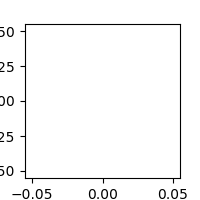

In [2]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

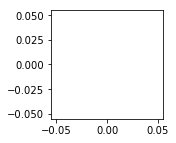

In [3]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [4]:
dfmg = pd.read_csv("dfmg_glDist.csv")
del dfmg['Unnamed: 0']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])

In [9]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

import plot_station_bot_sal as pbs

import plot_topView_contourf as topView
importlib.reload(topView)

import plot_monthly_count as monthCount
importlib.reload(monthCount)

import plot_theta_sal
importlib.reload(plot_theta_sal)

import plot_year_vs_salAverages as pltSalYearAvg
importlib.reload(pltSalYearAvg)

import plot_profiles_vs_dist as profDist

import plot_Profiles_vs_time as profile2dTime

In [6]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 80)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8)
Prydz = (box9 | box10)
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea

dfmg['mab'] = abs(dfmg['ECHODEPTH'] - dfmg['DEPTH'])
lt60 = abs(dfmg['mab']) < 60
lt100 = abs(dfmg['mab']) < 100
lt200 = abs(dfmg['mab']) < 200

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

deep_mask = dfmg['deep_flag'] == 1.0
deep_mask = deep_mask + (dfmg['ECHODEPTH'] < 100)

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [7]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [8]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

In [10]:
importlib.reload(profile2dTime)

<module 'plot_Profiles_vs_time' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_Profiles_vs_time.py'>

In [12]:
salrange = list(np.arange(33.5, 35.05, 0.01))
thetarange = list(np.arange(-3, 1, 0.01))

In [13]:
f_h_2, depth_bins = profile2dTime.plot_sal_contours_with_time(dfmg[Ross&gline_le_75km], 
                                          years=[2010, 2011, 2012, 2014], depth_max=-650, zbin=20, 
                                          levs=salrange, save=False, type=1, wd=4*4, plot=False)

In [9]:
evap_total = []
evap_start_year, evap_end_year = 2007, 2015
for i in range(evap_start_year, evap_end_year+1, 1):
    evap_total.append(xr.open_dataset("/media/data/Datasets/AirSeaFluxes/WHOIevap/evapr_oaflux_"+str(i)+".nc"))

In [7]:
evapmerged = xr.open_dataset("/media/data/Datasets/AirSeaFluxes/WHOIevap/evapr_merged_2007_2015.nc")

In [359]:
evap_monthly = np.zeros(12)
for i in range(12):
    evap_monthly[i] = np.nanmean(evap_total[0].evapr.isel(time=i).values) * float(monthrange(2004, i+1)[1])/365.25
    print(np.nanmean(evap_total[0].evapr.isel(time=i).values)  * float(monthrange(2004, i+1)[1])/365.25)

9.2143672569
8.39562964846
9.08289550242
8.51589206061
8.68005435217
8.51490447049
8.39843554442
8.40313366654
8.34684594048
9.00940957885
9.04527479672
9.31313865379


In [14]:
scalar = [1.4]
np.isscalar(scalar)

False

In [16]:
precip = xr.open_dataset("/media/data/Datasets/AirSeaFluxes/GPCPprecip/precip.mon.mean.nc")
precip_error = xr.open_dataset("/media/data/Datasets/AirSeaFluxes/GPCPprecip/precip.mon.mean.error.nc")

In [59]:
yearmask = (pd.Series(precip.time).dt.year >= 2007) & (pd.Series(precip.time).dt.year <= 2015)

In [60]:
precip.time

<xarray.DataArray 'time' (time: 469)>
array(['1979-01-01T00:00:00.000000000', '1979-02-01T00:00:00.000000000',
       '1979-03-01T00:00:00.000000000', '1979-04-01T00:00:00.000000000',
       '1979-05-01T00:00:00.000000000', '1979-06-01T00:00:00.000000000',
       '1979-07-01T00:00:00.000000000', '1979-08-01T00:00:00.000000000',
       '1979-09-01T00:00:00.000000000', '1979-10-01T00:00:00.000000000',
       '1979-11-01T00:00:00.000000000', '1979-12-01T00:00:00.000000000',
       '1980-01-01T00:00:00.000000000', '1980-02-01T00:00:00.000000000',
       '1980-03-01T00:00:00.000000000', '1980-04-01T00:00:00.000000000',
       '1980-05-01T00:00:00.000000000', '1980-06-01T00:00:00.000000000',
       '1980-07-01T00:00:00.000000000', '1980-08-01T00:00:00.000000000',
       '1980-09-01T00:00:00.000000000', '1980-10-01T00:00:00.000000000',
       '1980-11-01T00:00:00.000000000', '1980-12-01T00:00:00.000000000',
       '1981-01-01T00:00:00.000000000', '1981-02-01T00:00:00.000000000',
       '1981-

In [28]:
precip.precip.isel(time=slice(0,-1)).values.shape[0]

468

In [323]:
len(evap.lon)

360

In [325]:
len(precip.lon)

144

In [326]:
evap.lon[180]

<xarray.DataArray 'lon' ()>
array(180.5, dtype=float32)
Coordinates:
    lon      float32 180.5
Attributes:
    long_name: longitude
    units: degrees
    range: 0.5 to 359.5

In [332]:
np.asscalar(np.argmin(np.abs(precip.lon - 180.5) ))

72

In [333]:
precip.lon[72 : -1]

<xarray.DataArray 'lon' (lon: 71)>
array([ 181.25,  183.75,  186.25,  188.75,  191.25,  193.75,  196.25,
        198.75,  201.25,  203.75,  206.25,  208.75,  211.25,  213.75,
        216.25,  218.75,  221.25,  223.75,  226.25,  228.75,  231.25,
        233.75,  236.25,  238.75,  241.25,  243.75,  246.25,  248.75,
        251.25,  253.75,  256.25,  258.75,  261.25,  263.75,  266.25,
        268.75,  271.25,  273.75,  276.25,  278.75,  281.25,  283.75,
        286.25,  288.75,  291.25,  293.75,  296.25,  298.75,  301.25,
        303.75,  306.25,  308.75,  311.25,  313.75,  316.25,  318.75,
        321.25,  323.75,  326.25,  328.75,  331.25,  333.75,  336.25,
        338.75,  341.25,  343.75,  346.25,  348.75,  351.25,  353.75,
        356.25], dtype=float32)
Coordinates:
  * lon      (lon) float32 181.25 183.75 186.25 188.75 191.25 193.75 196.25 ...
Attributes:
    units: degrees_east
    long_name: Longitude
    actual_range: [   1.25  358.75]
    standard_name: longitude
    axis: X

In [340]:
def find_lonlat_indices_evap(evap_year, lon, lat):
    if(lon >=0 & lon <= 180):
        longrid = evap_year.lon.values
    else:
        longrid = evap_year.lon.values
        longrid[180:360] = evap_year.lon.values[180:360] - 360
    
    return np.asscalar(np.argmin(np.abs(longrid - lon))), np.asscalar(np.argmin(np.abs(evap_year.lat - lat)))

def find_lonlat_indices_precip(precip, time, lon, lat):
    if(lon >=0 & lon <= 180):
        longrid = precip.lon.values
    else:
        longrid = precip.lon.values
        mid_ind = np.asscalar(np.argmin(np.abs(precip.lon - 180.5) ))
        longrid[mid_ind : -1] = precip.lon.values[mid_ind:-1] - 360
    time_ind = np.asscalar(np.argmin(np.abs(precip.time - time )))
    return time_ind, np.asscalar(np.argmin(np.abs(longrid - lon))), np.asscalar(np.argmin(np.abs(precip.lat - lat)))

In [107]:
find_lonlat_indices_evap(evap[0], 160, -80)

(159, 9)

#### Evaporation is in cm/yr
#### Precip is in mm/yr

In [ ]:
    for i in range(12):
        E_mon_mean[i] = E[i].mean()
        P_mon_mean[i] = P[i].mean()
    plt.plot(E_mon_mean - P_mon_mean, np.arange(12))
    plt.show()

In [321]:
from calendar import monthrange
monthrange(2012, 1)[1]

31

In [335]:
def freshwater_flux_compute(evap_total, precip, year, lonmin, lonmax, latmin, latmax, wd=7, ht=4):
    from calendar import monthrange
    
    evap = evap_total[year - evap_start_year]
    elonminind , elatminind = find_lonlat_indices_evap(evap, lonmin, latmin)
    elonmaxind, elatmaxind = find_lonlat_indices_evap(evap, lonmax, latmax)
    
    ptimeminind, plonminind, platminind = find_lonlat_indices_precip(precip, np.datetime64(str(year)+"-01-01"), 
                                                                     lonmin, latmin)
    ptimemaxind, plonmaxind, platmaxind = find_lonlat_indices_precip(precip, np.datetime64(str(year)+"-12-01"), 
                                                                     lonmax, latmax)
    print(elonminind, elonmaxind, plonminind, plonmaxind)
    E = evap.evapr.isel(lon=slice(elonminind, elonmaxind), lat=slice(elatminind, elatmaxind)).values*10
    E_err = evap.err.isel(lon=slice(elonminind, elonmaxind), lat=slice(elatminind, elatmaxind)).values*10
    
    P = precip.precip.isel(time=slice(ptimeminind, ptimemaxind+1), lon=slice(plonminind, plonmaxind), 
                          lat=slice(platminind, platmaxind)).values
    P_err = precip_error.precip.isel(time=slice(ptimeminind, ptimemaxind+1), lon=slice(plonminind, plonmaxind), 
                          lat=slice(platminind, platmaxind)).values
    
    E_mon_mean, P_mon_mean = np.zeros(12), np.zeros(12)
    E_mon_mean_err, P_mon_mean_err = np.zeros(12), np.zeros(12)
    
    for i in range(12):
        E_mon_mean[i] = np.nanmean(E[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
        E_mon_mean_err[i] = np.nanmean(E_err[i]) * float(monthrange(year, i+1)[1]) / 365.25 # to convert cm/yr to mm/month
        
        P_mon_mean[i] = np.nanmean(P[i]) * float(monthrange(year, i+1)[1])
        P_mon_mean_err[i] = np.nanmean(P_err[i]) * float(monthrange(year, i+1)[1])
        
    E_mon_mean[np.isnan(E_mon_mean)] = 0.0
    E_mon_mean_err[np.isnan(E_mon_mean_err)] = 0.0
    
    P_mon_mean[np.isnan(P_mon_mean)] = 0.0
    P_mon_mean_err[np.isnan(P_mon_mean_err)] = 0.0
    
    print(E_mon_mean, "\n\n", P_mon_mean) 
    
    fig, ax = plt.subplots(figsize=(wd, ht))
    ax.errorbar(np.arange(1,13,1), E_mon_mean - P_mon_mean, yerr=(E_mon_mean_err+P_mon_mean_err), capsize=3, fmt='o', 
                markersize=5)
    ax.set_xticks(np.arange(1,13,1))
    ax.set_xticklabels(month_names)
    plt.show()
    return np.nansum(E_mon_mean) - np.nansum(P_mon_mean), np.nansum(E_mon_mean), np.nansum(P_mon_mean)

In [360]:
a = np.zeros(5)

159 171 63 68
[ 29.52380952  55.28450833  80.79945243   0.           0.           0.           0.
   0.           0.           0.           0.          29.12699894] 

 [ 33.31284725  29.76464451  23.6126107   15.23978933   6.99689883
   6.51847465   7.68658788  12.34725774  14.02720298  10.88683628
   6.52766204   8.97267878]


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


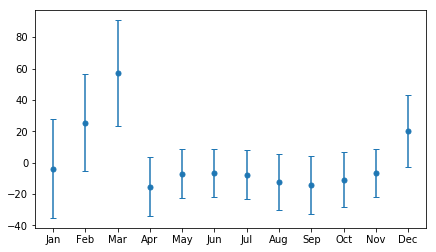

In [362]:
a[0],_ ,_ = freshwater_flux_compute(evap_total, precip, 2010, 160, 172, -80, -72)

In [363]:
a[0]

18.841278260247179

In [278]:
precip.lon[68]

<xarray.DataArray 'lon' ()>
array(171.25, dtype=float32)
Coordinates:
    lon      float32 171.25
Attributes:
    units: degrees_east
    long_name: Longitude
    actual_range: [   1.25  358.75]
    standard_name: longitude
    axis: X

64 71 25 28
[ 140.98073726  116.81423682  109.67943678  108.64124377  119.87394153
  147.69551188  134.50004889  122.28980151  103.41683778  102.48581207
  112.73687298  140.19020241] 

 [  22.1422872     5.41855643   23.32538713   57.86885574  172.23982315
  131.29219063   86.40239654  124.36753702   65.96346548  162.12158181
  123.00920308   85.91658918]


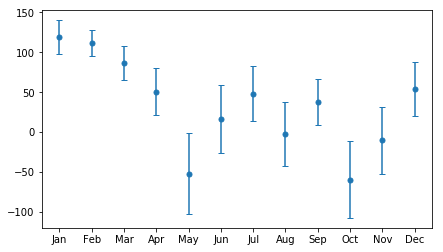

(399.23681029788168, 1459.3046836804538, 1060.0678733825721)

In [414]:
freshwater_flux_compute(evap_total, precip, 2011, 65, 72, 0, 20)

159 171 63 68
[ 22.27454559  33.77047684  53.3853525    0.           0.           0.           0.
   0.           0.           0.          43.20328542  18.00164271] 

 [  8.48293475  22.65322299  19.87335483  12.34718457  35.3941864
  12.43333865  15.18492905  31.11863043  16.84800245  17.46546207
   9.43056143  15.78096317]


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


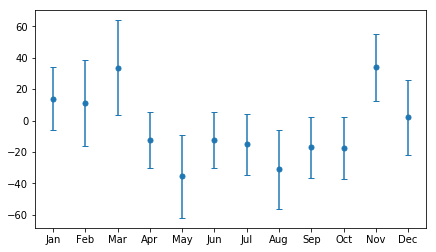

(-46.377467731043396, 170.63530306487186, 217.01277079591526)

In [338]:
freshwater_flux_compute(evap_total, precip, 2012, 160, 172, -80, -72)

159 171 63 68
[ 34.98628099  50.13552361   0.           0.           0.           0.           0.
   0.           0.           0.           0.          17.24626968] 

 [ 19.06677214  30.41659991  21.33631271   9.67543745  27.18782745
  13.0820782   12.93543868  40.06263179  16.26553514  38.07299192
   6.65040784   4.85092015]


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


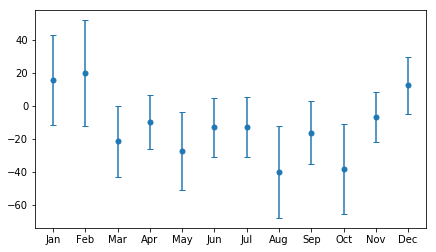

(-137.2348790851988, 102.36807427908221, 239.60295336428101)

In [339]:
freshwater_flux_compute(evap_total, precip, 2014, 160, 172, -80, -72)

313 339 125 135
[  8.12550884  20.01518263   0.           0.           0.           0.           0.
   0.           0.           0.           0.          15.56011864] 

 [ 23.76651835  13.78503882  14.46429414   5.17665442   5.02897753
  14.74105462  27.41065078  13.70275673  43.88724925  34.84254701
  16.38855458  23.92844681]


/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


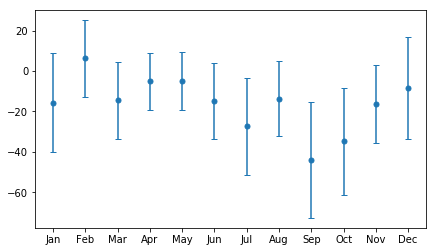

(-193.42193293210175, 43.700810111271579, 237.12274304337333)

In [341]:
freshwater_flux_compute(evap_total, precip, 2007, -46, -20, -80, -72)

# Sea Ice mass 
data obtained from NASA's Global Modeling and Assimilation Office
The data product is called: GEOS-S2S1
Sea-ice component is an assimilated product from MOM ocean model and available observations 
Ref: https://gmao.gsfc.nasa.gov/products/climateforecasts/GEOS5/DESC/index.php

In [2]:
seaice = xr.open_dataset("/media/data/Datasets/SeaIce/ocn_ana_2D_ll.nc")

In [7]:
seaice.sim

<xarray.DataArray 'sim' (time: 293, lat: 181, lon: 360)>
[19091880 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01T12:00:00 1993-02-01T12:00:00 ...
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 -85.0 -84.0 -83.0 ...
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 -174.0 ...
Attributes:
    long_name: frozen_water_mass
    units: kg m-2
    fmissing_value: 1e+15
    vmin: -1e+15
    vmax: 1e+15

In [51]:
monthmask = pd.to_datetime( pd.Series(seaice.time)).dt.month == 1

In [53]:
seaice.sim.isel(time=monthmask).time

<xarray.DataArray 'time' (time: 25)>
array(['1993-01-01T12:00:00.000000000', '1994-01-01T12:00:00.000000000',
       '1995-01-01T12:00:00.000000000', '1996-01-01T12:00:00.000000000',
       '1997-01-01T12:00:00.000000000', '1998-01-01T12:00:00.000000000',
       '1999-01-01T12:00:00.000000000', '2000-01-01T12:00:00.000000000',
       '2001-01-01T12:00:00.000000000', '2002-01-01T12:00:00.000000000',
       '2003-01-01T12:00:00.000000000', '2004-01-01T12:00:00.000000000',
       '2005-01-01T12:00:00.000000000', '2006-01-01T12:00:00.000000000',
       '2007-01-01T12:00:00.000000000', '2008-01-01T12:00:00.000000000',
       '2009-01-01T12:00:00.000000000', '2010-01-01T12:00:00.000000000',
       '2011-01-01T12:00:00.000000000', '2012-01-01T12:00:00.000000000',
       '2013-01-01T12:00:00.000000000', '2014-01-01T12:00:00.000000000',
       '2015-01-01T12:00:00.000000000', '2016-01-01T12:00:00.000000000',
       '2017-01-01T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time 

In [35]:
np.nanstd(seaice.sim.isel(time=slice(0,-1), lat=slice(0,20), lon=(160,170)).values)

108.79753913122609

In [3]:
def find_lonlat_indices_seaice(seaice, time, lon, lat):
    time_ind = np.asscalar(np.argmin(np.abs(seaice.time - time )))
    
    return time_ind, np.asscalar(np.argmin(np.abs(seaice.lon - lon))), np.asscalar(np.argmin(np.abs(seaice.lat - lat)))

In [381]:
find_lonlat_indices_seaice(seaice, np.datetime64('2010-09'), 160, -80)

(212, 340, 10)

In [382]:
find_lonlat_indices_seaice(seaice, np.datetime64('2010-09'), 172, -72)

(212, 352, 18)

In [4]:
seaice.sim.isel(time=slice(0, -1), lon=slice(340, 352), lat=slice(10, 18)).max()

<xarray.DataArray 'sim' ()>
array(2277.3662109375)

In [5]:
seaice.sim.isel(time=212, lon=slice(340, 352), lat=slice(10, 18)).min()

<xarray.DataArray 'sim' ()>
array(69.57418823242188)
Coordinates:
    time     datetime64[ns] 2010-09-01T12:00:00

In [389]:
year = 2007
np.datetime64(str(year)+'-01')

numpy.datetime64('2007-01')

In [12]:
def find_sim_freshwater_h(seaice, year, lonmin, lonmax, latmin, latmax, plot=False):
    timeind, lonminind, latminind = find_lonlat_indices_seaice(seaice, np.datetime64(str(year)+'-01'), lonmin, latmin)
    _, lonmaxind, latmaxind = find_lonlat_indices_seaice(seaice, np.datetime64(str(year)+'-01'), lonmax, latmax)
    sim_monthly_area_average = np.zeros(12)
    sim_monthly_area_max = np.zeros(12)
    for i in range(12):
        sim_monthly_area_average[i] = seaice.sim.isel(time=timeind+i, lon=slice(lonminind, lonmaxind), 
                                                      lat=slice(latminind, latmaxind)).mean()
        sim_monthly_area_max[i] = seaice.sim.isel(time=timeind+i, lon=slice(lonminind, lonmaxind), 
                                                      lat=slice(latminind, latmaxind)).mean()
    
    if(plot==True):
        plt.plot(np.arange(1,13,1), sim_monthly_area_max, 'o')
        plt.grid()
        plt.show()
    minind, maxind = np.nanargmin(sim_monthly_area_average), np.nanargmax(sim_monthly_area_average)
    
    mass_diff = sim_monthly_area_average[maxind] - sim_monthly_area_average[minind]
    
    fh = mass_diff / 1030. * 1e3
    print(mass_diff, sim_monthly_area_average[maxind], sim_monthly_area_average[minind])
    return fh

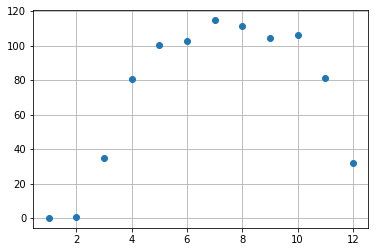

114.579534773 114.708729907 0.129195134186


111.24226676950873

In [14]:
find_sim_freshwater_h(seaice, 2014, 160, 180, -80, -72, plot=True)

In [411]:
seaice

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 293)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01T12:00:00 1993-02-01T12:00:00 ...
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 -85.0 -84.0 -83.0 ...
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 -176.0 -175.0 -174.0 ...
Data variables:
    SS       (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    sic      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    sim      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    sit      (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = seasonal/ocn_ana_2D_ll; Translation Date = 2018-03-21T04:05:19.781Z
    Contact: http://www.gmao.nasa.gov
    Title: Seasonal OCN_ANA_2D_ll
    Conventions: CF-1.0
    Source: http://www.gmao.nasa.gov
    geospatial_lat_min: -90.0
    geospatial_l

In [ ]:
area